# Part 6 - Exploring the Essemble of Random Forests

Aggregating The ALE partial effects, so that vegetation classes would be included in ALE plots even if the particular variable is not its top 5. 

## General Set up

In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("paper")

from joblib import load
from pygam import LinearGAM
from matplotlib.patches import Rectangle
import string
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
results_dir = 'E:/Krish_New/Dynamic_Vegetation_Project_Storage/Random_Forest_Results_On_Super_Group_Results'
results_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/RESULTS/Random_Forest_Results_On_Super_Group_Results_new'
directory = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/DATASETS/MODELLED_TRAINING_DATA'
plots_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/Thesis/Plots_For_Thesis/Chapter 3'

In [3]:
SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460']

MEAN_ANNUAL_CLIMATE_FEATURES = ['MAT', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

TOPOGRAPHIC_FEATURES = ['aspect_1s', 'twi_1s']

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + TEMP_FEATURES + SOIL_FEATURES + TOPOGRAPHIC_FEATURES

TEMPORAL_FEATURES = SEASONAL_FEATURES + PRECIP_FEATURES + VPD_FEATURES + CO2_FEATURES + TEMP_FEATURES
SPATIAL_FEATURES = SOIL_FEATURES + TOPOGRAPHIC_FEATURES + MEAN_ANNUAL_CLIMATE_FEATURES

TARGET = ['pv_filter', 'npv_filter', 'bs_filter']

In [4]:
# Remove outlier via 1.5 * IQR method 

def remove_outliers_from_df(df, variable):
    lower_q, upper_q = df[variable].quantile([0.25, 0.75]) # get lower and upper quartiles 
    iqr = upper_q - lower_q
    lower_b, upper_b = lower_q - 1.5*iqr, upper_q + 1.5*iqr # generate lower and upper bounds, however, limit the lower bounds to '0'
    
    return df.loc[(df[variable] >= lower_b) & (df[variable]  <= upper_b)]
    
def perform_gam(df, x, y):
    
    #print(df[x])
    #print(df[y])
    gam = LinearGAM().fit(df[x], df[y])
    gam_pred = gam.predict(df[x])
    conf_95 =  gam.confidence_intervals(df[x])
    
    return [gam_pred, conf_95]

In [5]:
labels_alpha = [i for i in string.ascii_lowercase] # for the a-z labelling scheme 
labels_alpha_extension = ['a' + i for i in labels_alpha] # for the a-z labelling scheme 
labels_alpha = labels_alpha + labels_alpha_extension
#labels_alpha

## Temporal Desert 

In [6]:
veg_group_agg_importances_df = pd.read_csv(f'{results_dir}/Results_Visualisation/Aggregated_Importances_100repeats.csv').set_index('Unnamed: 0')

# Now extract the most important variables from the variable importances 
veg_group_agg_spatial = veg_group_agg_importances_df.iloc[veg_group_agg_importances_df.index.isin(TEMPORAL_FEATURES)] # note I removed the fire variables 
top_5_variables = {}

groups = np.unique(veg_group_agg_spatial['group'])
for g in groups:
    veg_group_agg_group = veg_group_agg_spatial[veg_group_agg_spatial['group'] == g].sort_values('0', ascending = False)
    veg_group_agg_group = veg_group_agg_group.loc[veg_group_agg_group[veg_group_agg_group.columns[0]] > 0]
    top_5_variables[veg_group_agg_group['group'].values[0]] = list(veg_group_agg_group.index)
print(top_5_variables)

{'Desert Chenopod': ['CO2', 'precip_90', 'precip_365', 'VPD_30', 'precip_180', 'VPD_14', 'tmin_14', 'VPD_7', 'photoperiod', 'precip_30', 'precip_730', 'tmax_30', 'VPD_lag', 'precip_1095', 'precip_1460', 'tmax_14', 'tmin_7', 'photoperiod_gradient', 'tmin_30'], 'Desert Forb': ['precip_90', 'VPD_30', 'CO2', 'tmax_14', 'tmin_7'], 'Desert Hummock.grass': ['CO2', 'precip_90', 'precip_365', 'precip_180', 'precip_730', 'precip_1095', 'precip_30', 'tmax_14', 'tmin_14', 'photoperiod_gradient', 'precip_1460', 'tmin_lag', 'VPD_30', 'photoperiod', 'VPD_7'], 'Desert Shrub': ['precip_90', 'CO2', 'photoperiod', 'photoperiod_gradient', 'precip_30', 'tmin_7', 'precip_180', 'precip_365', 'tmax_lag', 'tmax_30', 'precip_1460', 'VPD_30', 'tmin_14'], 'Desert Tree.Palm': ['CO2', 'precip_90', 'photoperiod', 'precip_365', 'VPD_30', 'precip_730', 'photoperiod_gradient', 'VPD_14', 'tmax_14', 'precip_180', 'precip_30', 'VPD_7', 'tmin_14', 'precip_1095'], 'Desert Tussock.grass': ['CO2', 'precip_90', 'photoperiod_gr

In [7]:
sns.color_palette("hls", 11)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6548363636363637, 0.33999999999999997),
 (0.7815272727272726, 0.86, 0.33999999999999997),
 (0.4978909090909092, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.46574545454545463),
 (0.33999999999999997, 0.86, 0.7493818181818184),
 (0.33999999999999997, 0.6869818181818181, 0.86),
 (0.33999999999999997, 0.4033454545454544, 0.86),
 (0.560290909090909, 0.33999999999999997, 0.86),
 (0.8439272727272731, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.592436363636363)]

In [8]:
c_pal = sns.color_palette("hls", 11)
#['Forb', 'Chenopod', 'Hummock.grass', 'Tussock.grass', 'Shrub', 'Tree.Palm']
c_pal_ordered = [c_pal[2], c_pal[6], c_pal[3], 'forestgreen', c_pal[7],  c_pal[10]]

In [9]:
[c_pal[2], c_pal[6], c_pal[3], 'forestgreen', c_pal[7],  c_pal[10]]

[(0.7815272727272726, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.6869818181818181, 0.86),
 (0.4978909090909092, 0.86, 0.33999999999999997),
 'forestgreen',
 (0.33999999999999997, 0.4033454545454544, 0.86),
 (0.86, 0.33999999999999997, 0.592436363636363)]

In [10]:
# Now determining the variables to consider:
# We Just tally up the number of times a variable is top 5 
variables = []
for i, v in top_5_variables.items():
    for var in v:
        variables.append(var)

In [11]:
tally = pd.Series(variables).value_counts()
variable_list = tally.index[tally.values >= 4].values
print(tally)
print(variable_list)

CO2                     11
precip_90               11
precip_365              10
VPD_30                  10
precip_180              10
photoperiod_gradient    10
photoperiod             10
precip_30               10
VPD_7                    9
precip_730               9
tmax_14                  8
tmin_14                  8
tmin_7                   8
tmax_30                  7
precip_1095              7
precip_1460              6
VPD_lag                  6
VPD_14                   6
tmin_lag                 6
tmax_lag                 5
tmax_7                   5
tmin_30                  4
Name: count, dtype: int64
['CO2' 'precip_90' 'precip_365' 'VPD_30' 'precip_180'
 'photoperiod_gradient' 'photoperiod' 'precip_30' 'VPD_7' 'precip_730'
 'tmax_14' 'tmin_14' 'tmin_7' 'tmax_30' 'precip_1095' 'precip_1460'
 'VPD_lag' 'VPD_14' 'tmin_lag' 'tmax_lag' 'tmax_7' 'tmin_30']


In [12]:
variable_list = ['CO2', 'precip_30', 'precip_90', 'precip_180', 'precip_365', 'photoperiod', 'photoperiod_gradient', 'VPD_30'] 
variable_figure_readable = ['$CO_2$ (ppm)', 'PPT (1-30 days, mm)', 'PPT (31-90 days, mm)', 'PPT (91-180 days, mm)', 'PPT (181-365 days, mm)',
                           'PP (hrs)', '$\Delta$PP (1 day prior, hrs)', 'VPD (15-30 days, kPa)']

In [13]:
labels_2 = [i for i in string.ascii_lowercase]

['CO2', 'precip_30', 'precip_90', 'precip_180', 'precip_365', 'photoperiod', 'photoperiod_gradient', 'VPD_30']
pv_filter : CO2
npv_filter : CO2
bs_filter : CO2
pv_filter : precip_30
Skip: Desert Forb
npv_filter : precip_30
Skip: Desert Forb
bs_filter : precip_30
Skip: Desert Forb
pv_filter : precip_90
npv_filter : precip_90
bs_filter : precip_90
pv_filter : precip_180
Skip: Desert Forb
npv_filter : precip_180
Skip: Desert Forb
bs_filter : precip_180
Skip: Desert Forb
pv_filter : precip_365
Skip: Desert Forb
npv_filter : precip_365
Skip: Desert Forb
bs_filter : precip_365
Skip: Desert Forb
pv_filter : photoperiod
Skip: Desert Forb
npv_filter : photoperiod
Skip: Desert Forb
bs_filter : photoperiod
Skip: Desert Forb
pv_filter : photoperiod_gradient
Skip: Desert Forb
npv_filter : photoperiod_gradient
Skip: Desert Forb
bs_filter : photoperiod_gradient
Skip: Desert Forb
pv_filter : VPD_30
Skip: Temp/Med Tree.Palm
npv_filter : VPD_30
Skip: Temp/Med Tree.Palm
bs_filter : VPD_30
Skip: Temp/Med 

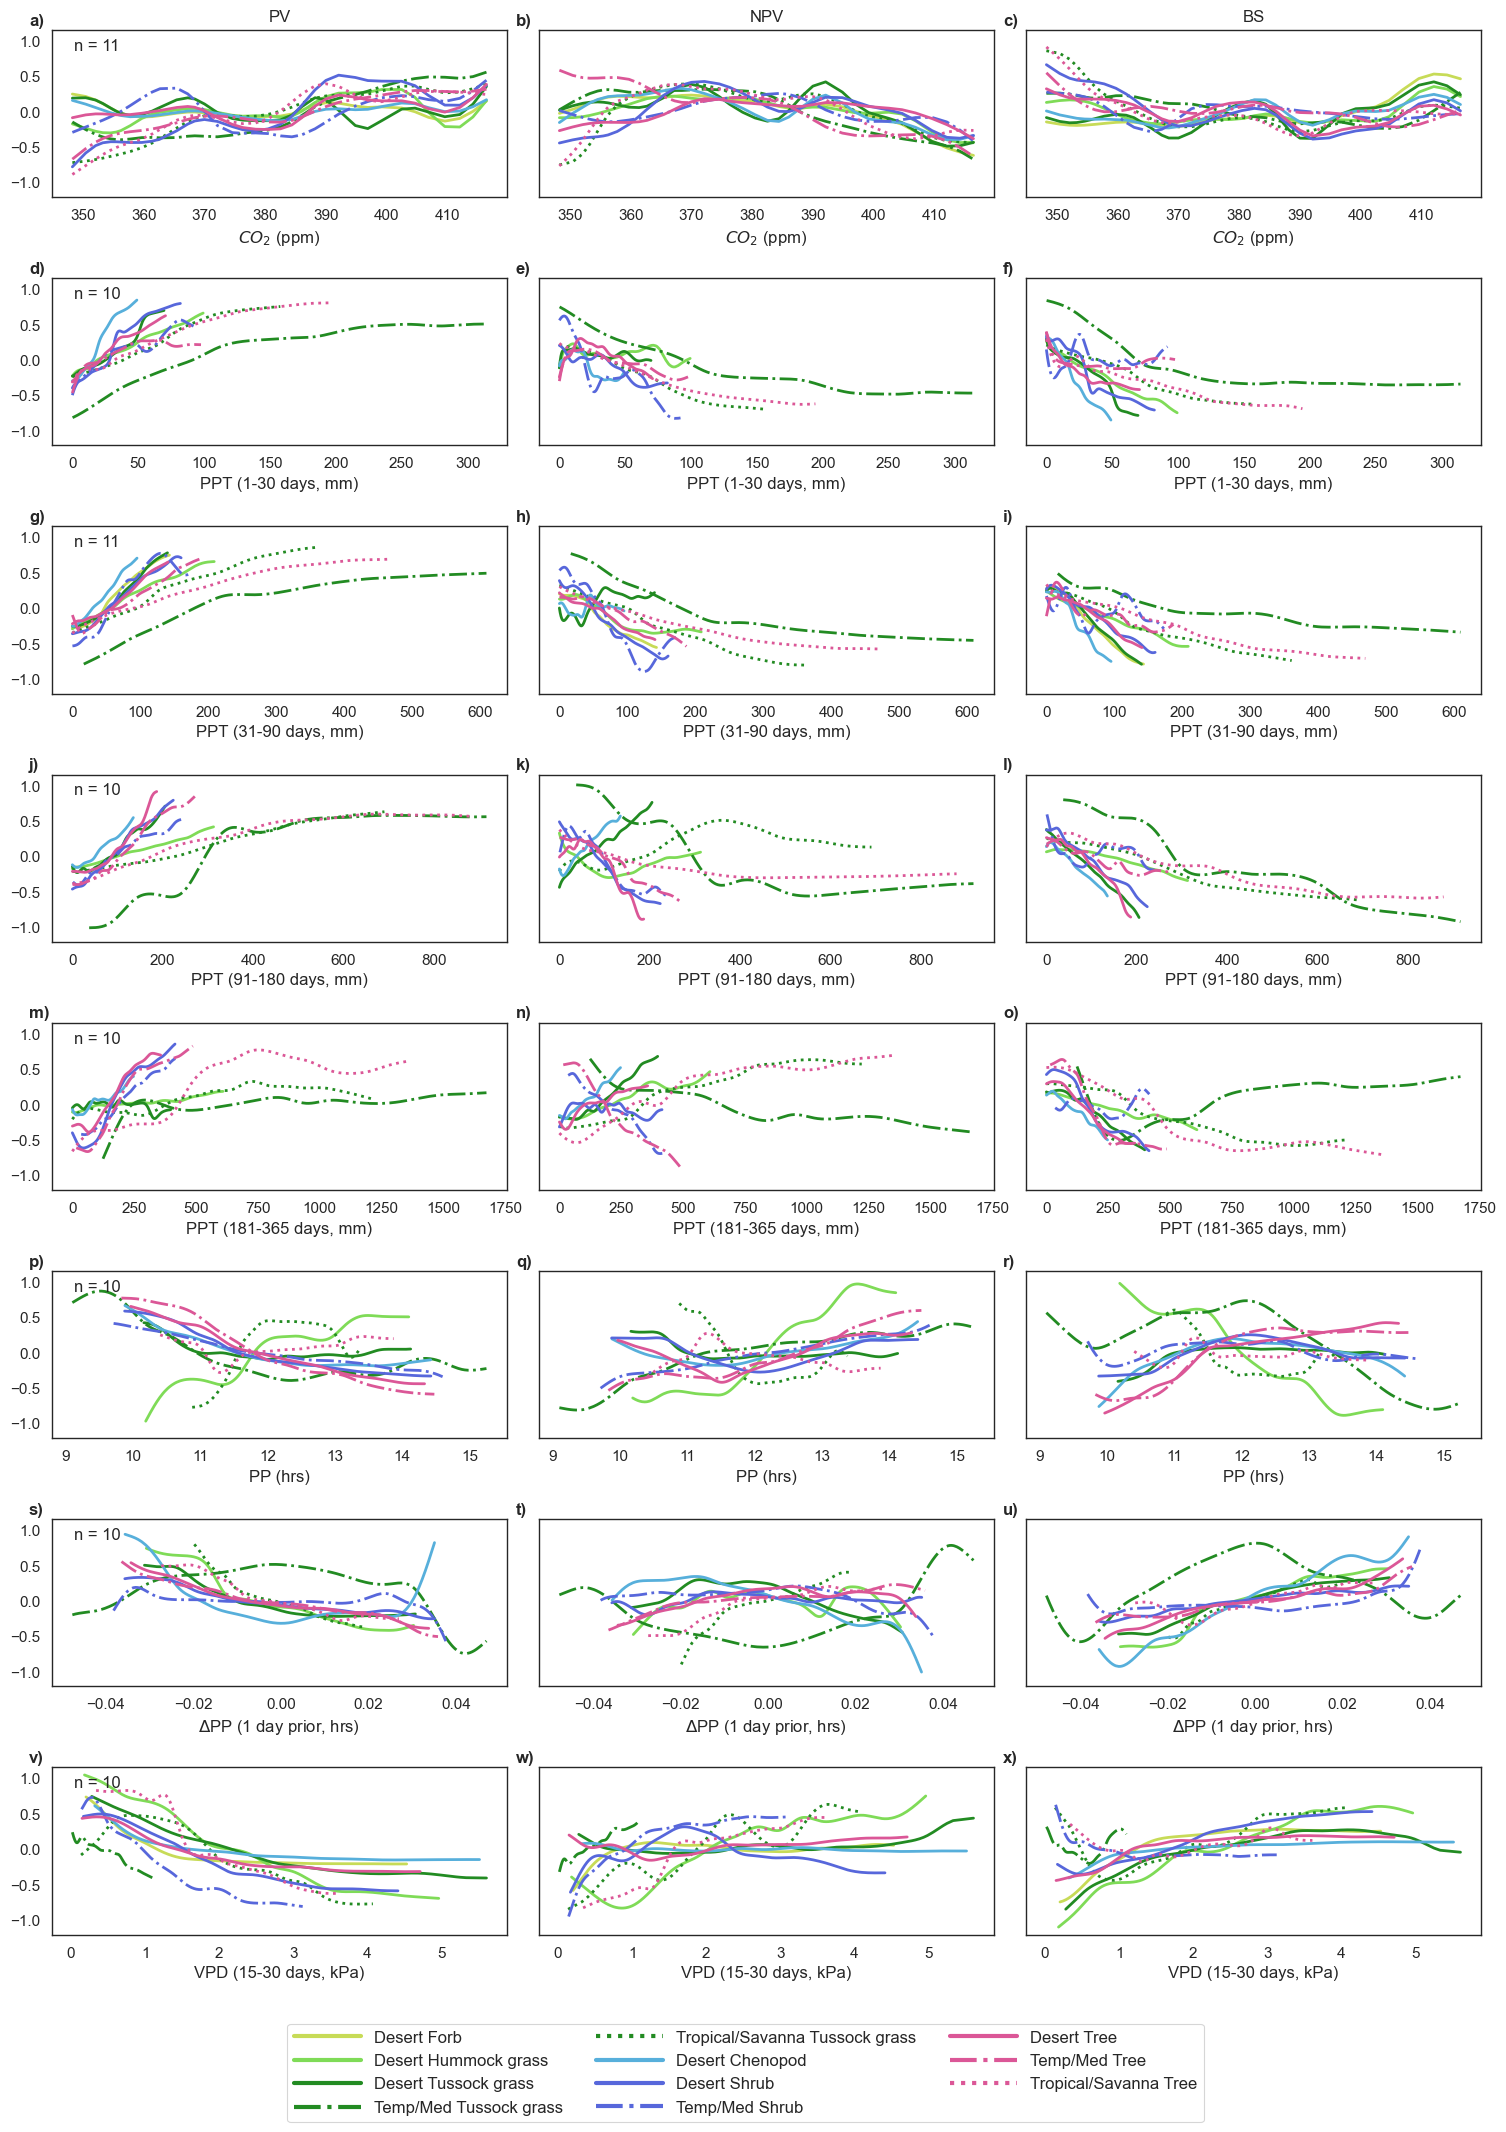

In [14]:
veg_list = ['Forb', 'Chenopod', 'Hummock.grass', 'Tussock.grass', 'Shrub', 'Tree.Palm']


ordered_veg_list = ['Desert Forb',                 'Desert Chenopod', 'Desert Hummock.grass',
                    'Desert Tree.Palm',            'Desert Shrub',    'Desert Tussock.grass',
                    'Temp/Med Tree.Palm',          'Temp/Med Shrub',  'Temp/Med Tussock.grass',
                    'Tropical/Savanna Tree.Palm',  'Tropical/Savanna Tussock.grass']

ordered_veg_list = ['Desert Forb', 'Desert Hummock.grass', 'Desert Tussock.grass',
                   'Temp/Med Tussock.grass', 'Tropical/Savanna Tussock.grass', 'Desert Chenopod',
                   'Desert Shrub', 'Temp/Med Shrub' ,
                    'Desert Tree.Palm', 'Temp/Med Tree.Palm',  'Tropical/Savanna Tree.Palm']

labels = ['Desert Forb', 'Desert Hummock grass', 'Desert Tussock grass',
                   'Temp/Med Tussock grass', 'Tropical/Savanna Tussock grass', 'Desert Chenopod',
                   'Desert Shrub', 'Temp/Med Shrub' ,
                    'Desert Tree', 'Temp/Med Tree',  'Tropical/Savanna Tree']


variable_list = variable_list
print(variable_list)
veg_list = ['Forb', 'Chenopod', 'Hummock.grass', 'Tussock.grass', 'Shrub', 'Tree.Palm']
biome_list = ['Desert', 'Temp/Med', 'Tropical/Savanna']
fractions_to_visualise =  ['pv_filter', 'npv_filter', 'bs_filter']
ncol =len(fractions_to_visualise)
nrow =  len(variable_list)

fig, axes = plt.subplots(ncols = ncol , nrows = nrow, figsize = (15,20), tight_layout=True, sharey = True)
fraction = 'pv_filter'

line_types = ['-','dashdot', 'dotted']
colour_indx = []

lower = -1 
higher = 1

row_counter = 0
for i, ax in enumerate(axes.flat):
    
    fraction = fractions_to_visualise[i % ncol]
    
    if i % ncol == 0 and i > 0:
        row_counter += 1
    variable = variable_list[row_counter]
    
    
    print(f'{fraction} : {variable}')
        
    for veg_idx, veg_class in enumerate(ordered_veg_list):
        
        # Check if its in the top 5 variables 
        if variable not in top_5_variables[veg_class]:
            print(f'Skip: {veg_class}')
            continue

        super_group_folder_name = '_'.join(veg_class.split('/')) 
        ALE_all_models_df = pd.read_csv(f'{results_dir}/Results_Visualisation/ALE_values_{super_group_folder_name}.csv')

        x_variable = variable + '_feat_values'
        y_variable = variable
        
        # Remove outliers 
        fraction_ALE = ALE_all_models_df.loc[ALE_all_models_df['Target'] == fraction][[x_variable, y_variable, 'Model']].dropna()
        fraction_ALE_removed_outlier = remove_outliers_from_df(fraction_ALE, x_variable).sort_values(x_variable)
        
        # Scale the ALE values
        fraction_ALE_removed_outlier[y_variable] = MaxAbsScaler().fit_transform(fraction_ALE_removed_outlier[y_variable].values.reshape(-1, 1))
        
        # Since VPD_30 needs to be scaled to an average, for better intepretability
        if variable == 'VPD_30':
            fraction_ALE_removed_outlier[x_variable] =  fraction_ALE_removed_outlier[x_variable]/16 # since it coveres day 15 to 30 inclusive: 30 - 15 + 1
        
        # Perform GAM
        gam_pred, conf_95 = perform_gam(fraction_ALE_removed_outlier, x_variable, y_variable)
        
        # Deciding upon linestyle 
        biome = veg_class.split(' ')[0]
        line_type = line_types[biome_list.index(biome)]
        
        # Deciding upon line colour 
        veg_type = veg_class.split(' ')[1]
        line_colour = c_pal_ordered[veg_list.index(veg_type)]

        ax.plot(fraction_ALE_removed_outlier[x_variable], gam_pred, linewidth = 2, label = super_group_folder_name, color = line_colour, linestyle = line_type)
        #ax.fill_between(fraction_ALE_removed_outlier[x_variable], conf_95[:, 0],
        #                    conf_95[:, 1], alpha=0.2, label = '_Hidden', color = line_colour)
        
        xlab = variable_figure_readable[variable_list.index(y_variable)]
        ax.set_xlabel(xlab, fontsize=12)
        
        # Set title on only the first row
        if row_counter == 0:
            #ax.title.set_text()
            ax.set_title(fraction.split('_')[0].upper(), fontsize=12)
        
        
    # Annotate the number of veg class included
    if fraction == 'pv_filter':
        number_of_classes = len(ax.get_lines())
        ax.text(0.05, 0.95, f'n = {number_of_classes}', transform=ax.transAxes, 
            fontsize=12, va='top')
        
    ax.tick_params(axis='y', labelsize=11) 
    ax.tick_params(axis='x', labelsize=11) 
    ax.text(-0.05, 1.1, f'{labels_2[i]})', transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')

    

lines = []
for veg_idx, veg_class in enumerate(ordered_veg_list):
    
    biome = veg_class.split(' ')[0]
    veg_type = veg_class.split(' ')[1]
    
    line_type = line_types[biome_list.index(biome)]
    line_colour = c_pal_ordered[veg_list.index(veg_type)]
    
    lines.append(Line2D([0], [0], color=line_colour, linewidth=3, linestyle = line_type))
    
fig.legend(lines, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.01), handlelength = 4.0, fontsize=12)
fig.tight_layout()

In [15]:
#fig.savefig(f'{plots_dir}/Total_Normalised_Temporal_ALE_Comparison_Plots_v2.png', bbox_inches="tight")

# Now we consider the Spatial Variables

In [16]:
veg_group_agg_importances_df = pd.read_csv(f'{results_dir}/Results_Visualisation/Aggregated_Importances_100repeats.csv').set_index('Unnamed: 0')

# Now extract the most important variables from the variable importances 
veg_group_agg_spatial = veg_group_agg_importances_df.iloc[veg_group_agg_importances_df.index.isin(SPATIAL_FEATURES)] # note I removed the fire variables 
top_5_variables = {}

groups = np.unique(veg_group_agg_spatial['group'])
for g in groups:
    veg_group_agg_group = veg_group_agg_spatial[veg_group_agg_spatial['group'] == g].sort_values('0', ascending = False)
    print(veg_group_agg_group)
    veg_group_agg_group = veg_group_agg_group.loc[veg_group_agg_group[veg_group_agg_group.columns[0]] > 0]
    print(veg_group_agg_group)
    top_5_variables[veg_group_agg_group['group'].values[0]] = list(veg_group_agg_group.index)
print(top_5_variables)

                     0            group
Unnamed: 0                             
SLGA_3       59.106231  Desert Chenopod
MAT          57.449697  Desert Chenopod
aspect_1s     9.413123  Desert Chenopod
SLGA_2        7.029264  Desert Chenopod
DER_000_999   3.131438  Desert Chenopod
SLGA_1        2.187057  Desert Chenopod
MAP           0.988964  Desert Chenopod
twi_1s       -7.258529  Desert Chenopod
                     0            group
Unnamed: 0                             
SLGA_3       59.106231  Desert Chenopod
MAT          57.449697  Desert Chenopod
aspect_1s     9.413123  Desert Chenopod
SLGA_2        7.029264  Desert Chenopod
DER_000_999   3.131438  Desert Chenopod
SLGA_1        2.187057  Desert Chenopod
MAP           0.988964  Desert Chenopod
                     0        group
Unnamed: 0                         
MAT          57.766164  Desert Forb
SLGA_3        7.316108  Desert Forb
aspect_1s     5.681611  Desert Forb
twi_1s        2.311720  Desert Forb
SLGA_2        1.830905  

In [17]:
# Now determining the variables to consider:
# We Just tally up the number of times a variable is top 5 
variables = []
for i, v in top_5_variables.items():
    for var in v:
        variables.append(var)

In [18]:
tally = pd.Series(variables).value_counts()
variable_list = tally.index[tally.values >= 4].values
print(tally)
print(variable_list)

SLGA_3         10
MAP            10
MAT             9
aspect_1s       9
SLGA_1          9
SLGA_2          7
DER_000_999     7
twi_1s          6
Name: count, dtype: int64
['SLGA_3' 'MAP' 'MAT' 'aspect_1s' 'SLGA_1' 'SLGA_2' 'DER_000_999' 'twi_1s']


In [19]:
variable_list = ['MAP', 'MAT', 'SLGA_1', 'SLGA_2', 'SLGA_3', 'twi_1s', 'aspect_1s'] # Now format it according to my preferences, eg. alphabetical
variable_figure_readable = ['MAP (mm/yr)', 'MAT (${^{\circ}C/yr)}$', 'SLGA (PC1)', 'SLGA (PC2)', 'SLGA (PC3)', 'TWI', 'Aspect (${\circ}$)']

In [20]:
c_pal = sns.color_palette("hls", 11)
#['Forb', 'Chenopod', 'Hummock.grass', 'Tussock.grass', 'Shrub', 'Tree.Palm']
c_pal_ordered = [c_pal[2], c_pal[6], c_pal[3], 'forestgreen', c_pal[7],  c_pal[10]]

['MAP', 'MAT', 'SLGA_1', 'SLGA_2', 'SLGA_3', 'twi_1s', 'aspect_1s']
pv_filter : MAP
Skip: Desert Forb
npv_filter : MAP
Skip: Desert Forb
bs_filter : MAP
Skip: Desert Forb
pv_filter : MAT
Skip: Desert Shrub
Skip: Temp/Med Shrub
npv_filter : MAT
Skip: Desert Shrub
Skip: Temp/Med Shrub
bs_filter : MAT
Skip: Desert Shrub
Skip: Temp/Med Shrub
pv_filter : SLGA_1
Skip: Desert Tussock.grass
Skip: Desert Shrub
npv_filter : SLGA_1
Skip: Desert Tussock.grass
Skip: Desert Shrub
bs_filter : SLGA_1
Skip: Desert Tussock.grass
Skip: Desert Shrub
pv_filter : SLGA_2
Skip: Desert Hummock.grass
Skip: Desert Tussock.grass
Skip: Desert Shrub
Skip: Temp/Med Tree.Palm
npv_filter : SLGA_2
Skip: Desert Hummock.grass
Skip: Desert Tussock.grass
Skip: Desert Shrub
Skip: Temp/Med Tree.Palm
bs_filter : SLGA_2
Skip: Desert Hummock.grass
Skip: Desert Tussock.grass
Skip: Desert Shrub
Skip: Temp/Med Tree.Palm
pv_filter : SLGA_3
Skip: Desert Tussock.grass
npv_filter : SLGA_3
Skip: Desert Tussock.grass
bs_filter : SLGA_3


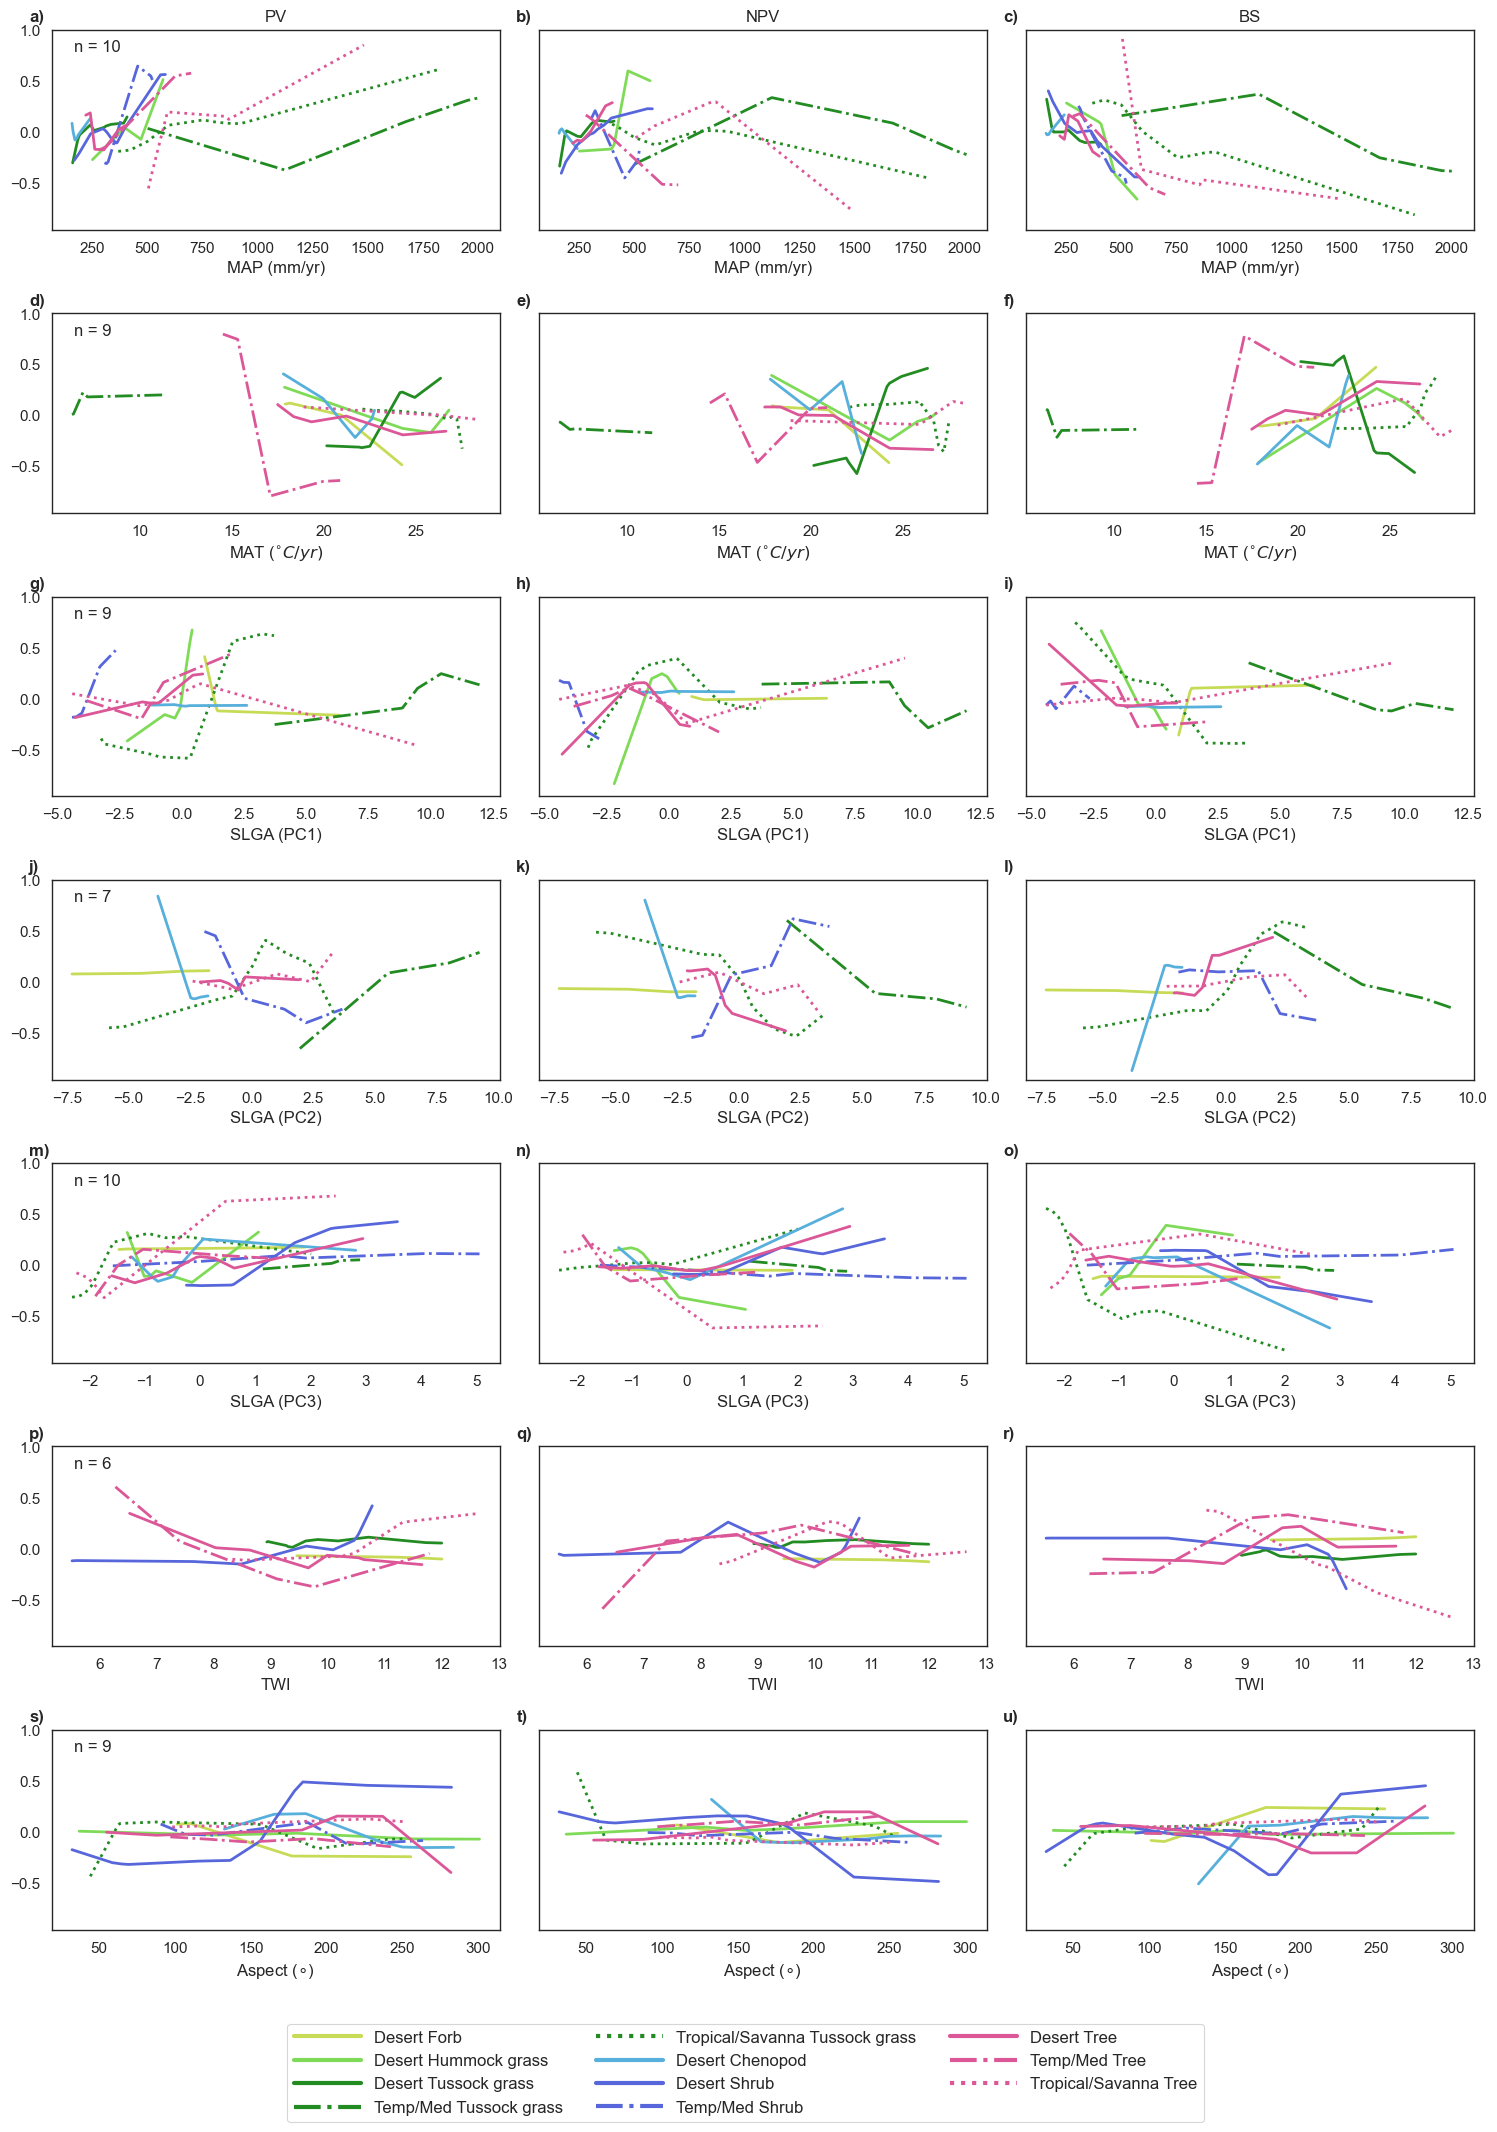

In [21]:
veg_list = ['Forb', 'Chenopod', 'Hummock.grass', 'Tussock.grass', 'Shrub', 'Tree.Palm']


ordered_veg_list = ['Desert Forb',                 'Desert Chenopod', 'Desert Hummock.grass',
                    'Desert Tree.Palm',            'Desert Shrub',    'Desert Tussock.grass',
                    'Temp/Med Tree.Palm',          'Temp/Med Shrub',  'Temp/Med Tussock.grass',
                    'Tropical/Savanna Tree.Palm',  'Tropical/Savanna Tussock.grass']

ordered_veg_list = ['Desert Forb', 'Desert Hummock.grass', 'Desert Tussock.grass',
                   'Temp/Med Tussock.grass', 'Tropical/Savanna Tussock.grass', 'Desert Chenopod',
                   'Desert Shrub', 'Temp/Med Shrub' ,
                    'Desert Tree.Palm', 'Temp/Med Tree.Palm',  'Tropical/Savanna Tree.Palm']

labels = ['Desert Forb', 'Desert Hummock grass', 'Desert Tussock grass',
                   'Temp/Med Tussock grass', 'Tropical/Savanna Tussock grass', 'Desert Chenopod',
                   'Desert Shrub', 'Temp/Med Shrub' ,
                    'Desert Tree', 'Temp/Med Tree',  'Tropical/Savanna Tree']

variable_list = variable_list
print(variable_list)
veg_list = ['Forb', 'Chenopod', 'Hummock.grass', 'Tussock.grass', 'Shrub', 'Tree.Palm']
biome_list = ['Desert', 'Temp/Med', 'Tropical/Savanna']
fractions_to_visualise =  ['pv_filter', 'npv_filter', 'bs_filter']
ncol =len(fractions_to_visualise)
nrow =  len(variable_list)
labels_2 = [i for i in string.ascii_lowercase]

lower = -1 
higher = 1

fig, axes = plt.subplots(ncols = ncol , nrows = nrow, figsize = (15,20), tight_layout=True, sharey = True)
fraction = 'pv_filter'

line_types = ['-','dashdot', 'dotted']
colour_indx = []

row_counter = 0
for i, ax in enumerate(axes.flat):
    
    fraction = fractions_to_visualise[i % ncol]
    
    if i % ncol == 0 and i > 0:
        row_counter += 1
    variable = variable_list[row_counter]
    
    
    print(f'{fraction} : {variable}')
    
        
    for veg_idx, veg_class in enumerate(ordered_veg_list):
        
        if variable not in top_5_variables[veg_class]:
            print(f'Skip: {veg_class}')
            continue

        super_group_folder_name = '_'.join(veg_class.split('/')) 
        ALE_all_models_df = pd.read_csv(f'{results_dir}/Results_Visualisation/ALE_values_{super_group_folder_name}.csv')

        x_variable = variable + '_feat_values'
        y_variable = variable
        
        # Skip the remove outliers bit
        fraction_ALE = ALE_all_models_df.loc[ALE_all_models_df['Target'] == fraction][[x_variable, y_variable, 'Model']].dropna()
        fraction_ALE_removed_outlier = fraction_ALE.sort_values(x_variable)
        
        # Scale the ALE values
        fraction_ALE_removed_outlier[y_variable] = MaxAbsScaler().fit_transform(fraction_ALE_removed_outlier[y_variable].values.reshape(-1, 1))
        
        # Perform GAM
        gam_pred, conf_95 = perform_gam(fraction_ALE_removed_outlier, x_variable, y_variable)
        
        # Deciding upon linestyle 
        biome = veg_class.split(' ')[0]
        line_type = line_types[biome_list.index(biome)]
        
        # Deciding upon line colour 
        veg_type = veg_class.split(' ')[1]
        line_colour = c_pal_ordered[veg_list.index(veg_type)]

        ax.plot(fraction_ALE_removed_outlier[x_variable], gam_pred, linewidth = 2, label = super_group_folder_name, color = line_colour, linestyle = line_type)
        
        # No confidence interval due to visual clutter.
        #ax.fill_between(fraction_ALE_removed_outlier[x_variable], conf_95[:, 0],
        #                    conf_95[:, 1], alpha=0.2, label = '_Hidden', color = line_colour)
        
        xlab = variable_figure_readable[variable_list.index(y_variable)]
        ax.set_xlabel(xlab, fontsize=12)
        
        # Set title on only the first row
        if row_counter == 0:
            ax.set_title(fraction.split('_')[0].upper(), fontsize=12)
        
       
        
    # Annotate the number of veg class included
    if fraction == 'pv_filter':
        number_of_classes = len(ax.get_lines())
        ax.text(0.05, 0.95, f'n = {number_of_classes}', transform=ax.transAxes, 
            fontsize=12, va='top')
        
    ax.tick_params(axis='y', labelsize=11) 
    ax.tick_params(axis='x', labelsize=11)
    ax.text(-0.05, 1.1, f'{labels_2[i]})', transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')


lines = []
for veg_idx, veg_class in enumerate(ordered_veg_list):
    
    biome = veg_class.split(' ')[0]
    veg_type = veg_class.split(' ')[1]
    
    line_type = line_types[biome_list.index(biome)]
    line_colour = c_pal_ordered[veg_list.index(veg_type)]
    
    lines.append(Line2D([0], [0], color=line_colour, linewidth=3, linestyle = line_type))
    
fig.legend(lines, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.01), handlelength = 4.0, fontsize=12)
fig.tight_layout()

In [22]:
#fig.savefig(f'{plots_dir}/Total_Normalised_Spatial_ALE_Comparison_Plots_v2.png', bbox_inches="tight")